In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchgeo.models import resnet50, ResNet50_Weights
from torchgeo.models import FarSeg
import sys
import os
from tqdm import tqdm
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
farseg_best = FarSeg(backbone="resnet50", classes=8, backbone_pretrained=False)

# Modify the first convolutional layer for 4-channel input
old_conv = farseg_best.backbone.conv1
new_conv = torch.nn.Conv2d(
    in_channels=4, out_channels=old_conv.out_channels, kernel_size=old_conv.kernel_size,
    stride=old_conv.stride, padding=old_conv.padding, bias=(old_conv.bias is not None),
)

# Initialize the first three channels with trained weights and the fourth with random values
state_dict = torch.load("models/farseg_model.pth", map_location=device)
new_conv.weight.data[:, :3, :, :] = state_dict["backbone.conv1.weight"][:, :3, :, :]
torch.nn.init.kaiming_normal_(new_conv.weight.data[:, 3:4, :, :])  # Random init for the 4th channel

# Replace the conv1 layer in the model
farseg_best.backbone.conv1 = new_conv
farseg_best.load_state_dict(state_dict, strict=False)

farseg_best.to(device)
farseg_best.eval()


FarSeg(
  (backbone): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [3]:
sys.path.append(os.path.abspath("src"))
from dataloader import FourBandSegDataset
from dataloader import skip_none_collate_fn
from dataloader import evaluate_model
# 1. Lecture du CSV complet
df_all = pd.read_csv("df_merged_extended.csv")

# 2. Filtrer uniquement les lignes alignées
df_filtered = df_all[df_all["alignment"] == True].copy().reset_index(drop=True)

# 3. Mélanger les données et definir les df pour chaque continent
df_filtered_shuffled = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

df_afrique = df_filtered_shuffled[df_filtered_shuffled["continent"] == "Africa"].copy().reset_index(drop=True)
df_asie = df_filtered_shuffled[df_filtered_shuffled["continent"] == "Asia"].copy().reset_index(drop=True)
df_europe = df_filtered_shuffled[df_filtered_shuffled["continent"] == "Europe"].copy().reset_index(drop=True)
df_north_america = df_filtered_shuffled[df_filtered_shuffled["continent"] == "North_america"].copy().reset_index(drop=True)
df_oceania = df_filtered_shuffled[df_filtered_shuffled["continent"] == "Oceania"].copy().reset_index(drop=True)
df_south_america = df_filtered_shuffled[df_filtered_shuffled["continent"] == "South_america"].copy().reset_index(drop=True)

df_without_afrique = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["Africa"])].copy().reset_index(drop=True)
df_without_asie = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["Asia"])].copy().reset_index(drop=True)
df_without_europe = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["Europe"])].copy().reset_index(drop=True)
df_without_north_america = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["North_america"])].copy().reset_index(drop=True)
df_without_oceania = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["Oceania"])].copy().reset_index(drop=True)
df_without_south_america = df_filtered_shuffled[~df_filtered_shuffled["continent"].isin(["South_america"])].copy().reset_index(drop=True)

# 4. Définir les proportions pour train / val / test
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Vérification: doit être égal à 1.0
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "La somme des ratios doit faire 1"

n_total = len(df_filtered_shuffled)
n_train = int(train_ratio * n_total)
n_val = int(val_ratio * n_total)
n_test = n_total - (n_train + n_val)

# Ajout d'une partie pour les tests sur chaque continent et sans ce continent
# Europe et Monde sans Europe pris en exemple
n_total_wo_continent = len(df_without_europe)
n_total_continent = len(df_europe)
print(n_total_wo_continent, n_total_continent)
n_train_continent = int(train_ratio * n_total_wo_continent)
n_val_continent = int(val_ratio * n_total_wo_continent)
n_test_continent = int(test_ratio * n_total_continent)

print("n_train:", n_train)
print("n_val:", n_val)
print("n_train + n_val:", n_train + n_val)
print("Total Europe Images:", len(df_europe))


# 5. Découpage en trois sous-ensembles
train_df = df_without_europe.iloc[:n_train].reset_index(drop=True)
val_df = df_without_europe.iloc[n_train:n_train+n_val].reset_index(drop=True)
test_df = df_europe.copy().reset_index(drop=True)


# 6. Instanciation des Dataset
train_dataset = FourBandSegDataset(train_df)
val_dataset = FourBandSegDataset(val_df)
test_dataset = FourBandSegDataset(test_df)

# 7. Création des DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=8,
    shuffle=True, num_workers=4, collate_fn=skip_none_collate_fn,
)
val_loader = DataLoader(
    val_dataset, batch_size=8,
    shuffle=False, num_workers=4, collate_fn=skip_none_collate_fn,
)
test_loader = DataLoader(
    test_dataset, batch_size=8,
    shuffle=False, num_workers=4, collate_fn=skip_none_collate_fn,
)

print("Taille Entraînement :", len(train_dataset))
print("Taille Validation   :", len(val_dataset))
print("Taille Test         :", len(test_dataset))

print("Chargement DataLoaders terminé.")

1464 120
n_train: 950
n_val: 316
n_train + n_val: 1266
Total Europe Images: 120
Taille Entraînement : 950
Taille Validation   : 316
Taille Test         : 120
Chargement DataLoaders terminé.


In [4]:
# Get some sample images from the test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get a batch of test images

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)
labels = labels.to(device)

# Forward pass through the model
with torch.no_grad():
    outputs = farseg_best(images)
predictions = torch.argmax(outputs, dim=1)  # Get the predicted segmentation masks


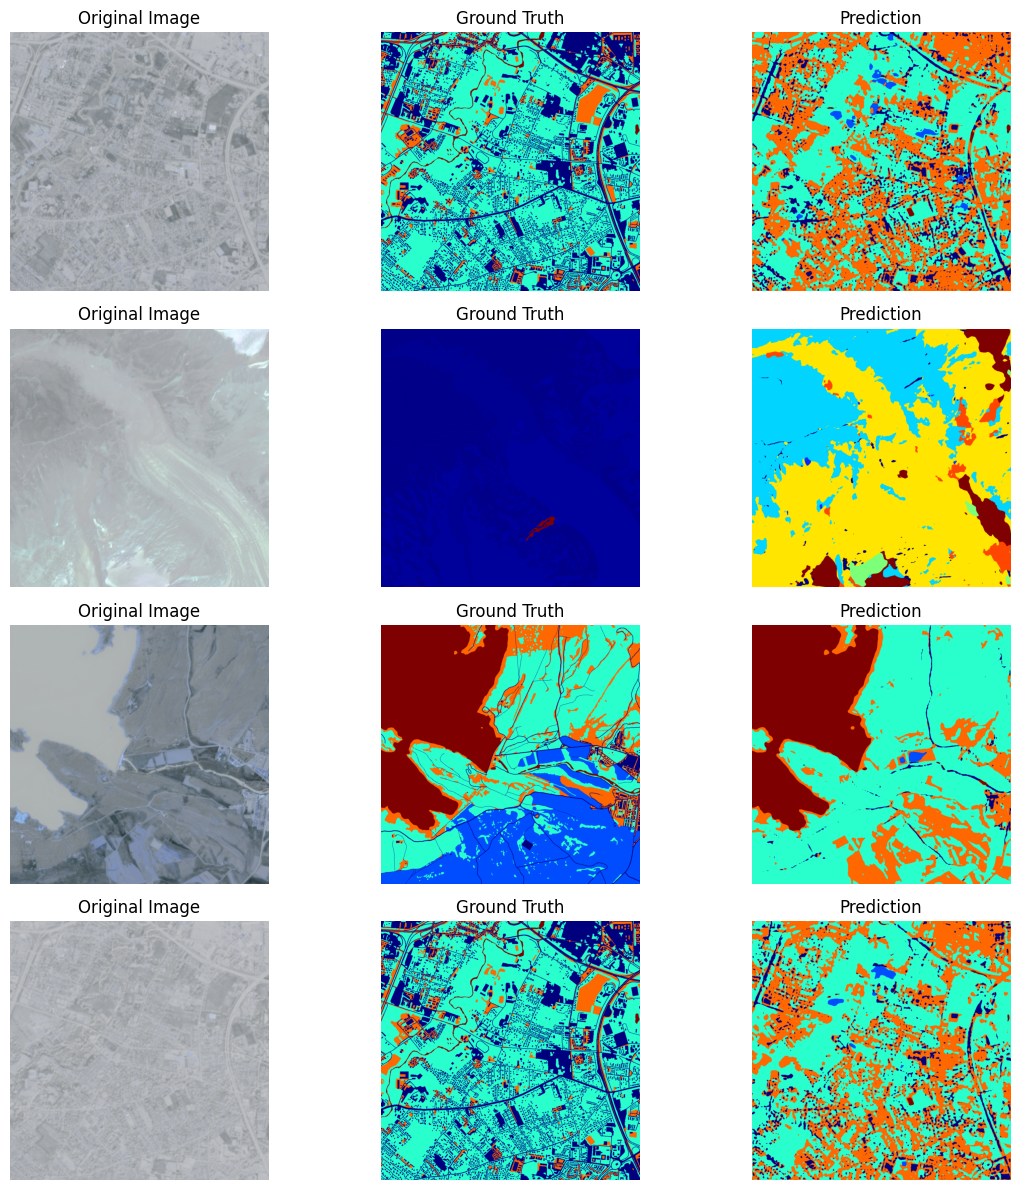

In [5]:
def visualize_results(images, labels, predictions, num_samples=4):
    """
    Visualize original images, ground truth masks, and predicted segmentation masks.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
    for i in range(num_samples):
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
        label = labels[i].cpu().numpy()
        pred = predictions[i].cpu().numpy()

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())
        img = (img * 255).astype("uint8")

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(label, cmap="jet")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred, cmap="jet")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_results(images, labels, predictions, num_samples=4)
